In [ ]:
%%HTML
<script src="require.js"></script>
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from math import sqrt

from olist.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers

seller_df = sellers[['seller_id', 'revenues', 'cost_of_reviews', 'profits', 'quantity']]
sellers_df = seller_df.sort_values(by='profits', ascending=True)
sellers_df

def updated(sellers_df, seller_id):
    # drop the seller
    sellers_df = sellers_df.iloc[seller_id:]

    # Calculate IT costs
    alpha = 3157.27
    beta = 978.23
    it_costs = alpha * np.sqrt(len(sellers_df)) + beta * np.sqrt(sellers_df['quantity'].sum())

    total_profits = sellers_df['profits'].sum() - it_costs
    total_revenues = sellers_df['revenues'].sum()
    profit_margin = (total_profits / total_revenues) * 100

    profits = sellers_df['profits'].sum() - it_costs

    return it_costs, profit_margin, profits

def optimal_n(sellers_df):
    # Initial profit margin and profits before removing any sellers
    total_profits = sellers_df['profits'].sum() - 500000
    total_revenues = sellers_df['revenues'].sum()
    initial_profit_margin = (total_profits / total_revenues) * 100

    initial_profits = sellers_df['profits'].sum() - 500000

    #profit_margin and profits after removing i sellers
    optimal_profit_margin = initial_profit_margin
    optimal_profits = initial_profits
    optimal_n_sellers = 0

    for i in range(len(sellers_df)):
        # Update IT costs, profit_margin, profits by removing i seller
        it_costs, profit_margin, profits = updated(sellers_df, i)

        # Check if current scenario improves profit margin and profits
        if profit_margin > optimal_profit_margin and profits > optimal_profits:
            optimal_profit_margin = profit_margin
            optimal_profits = profits
            optimal_n_sellers = i + 1  # Number of removed sellers


    return initial_profit_margin, initial_profits, optimal_n_sellers, optimal_profit_margin, optimal_profits

# Execute the code
initial_profit_margin, initial_profits, optimal_n_sellers, profit_margin, profits = optimal_n(sellers_df)

# Print the results
print("Initial profit margin:", initial_profit_margin)
print("Initial profit:", initial_profits)
print("Optimal number of sellers to remove:", optimal_n_sellers)
print("Optimal profit margin:", profit_margin)
print("Optimal profits:", profits)

dfs = []

for i in range(len(sellers_df)):
    # Update IT costs, profit_margin, profits by removing i seller
    it_costs, profit_margin, profits = updated(sellers_df, i)

    # Create a DataFrame for current iteration
    df = pd.DataFrame({'number_seller_removed': [i], 'profit_margin': [profit_margin], 'profits': [profits]})

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)
results_df.set_index('number_seller_removed', inplace=True)
results_df = round(results_df, 2)
bins = range(0, len(results_df), 100)

# Create a new column in your DataFrame that specifies the bin each row belongs to
results_df['bin'] = pd.cut(results_df.index, bins=bins, right=False)

# Group by the 'bin' column and calculate the mean for each bin
grouped_df = round(results_df.groupby('bin').mean(), 2)

# Rename the index name from 'bin' to 'number_seller_removed'
grouped_df = grouped_df.rename_axis('number_seller_removed')
grouped_df

Initial profit margin: 23.964535285415753
Initial profit: 667608.4440000001
Optimal number of sellers to remove: 856
Optimal profit margin: 46.91166362351736
Optimal profits: 1070976.1160162983


,profit_margin,profits
number_seller_removed,,
"[0, 100)",36.55,928820.03
"[100, 200)",43.56,1031749.98
"[200, 300)",45.02,1049895.07
"[300, 400)",45.66,1057949.38
"[400, 500)",45.97,1061889.75
"[500, 600)",46.13,1064809.67
"[600, 700)",46.31,1067376.12
"[700, 800)",46.49,1069357.84
"[800, 900)",46.81,1070512.32


# **How could Olist improve its profit** ❓

## What can influence Olist's profit

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- Comments of the bad reviews showed that some were linked to the `seller` or to the `product` itself.

## Should Olist remove under-performing sellers from its marketplace?

### Revenues
Sales fees: Olist takes a 10% cut on the product price (excl. freight) of each order delivered\
Subscription fees: Olist charges 80 BRL by month per seller

### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold. \
\
IT_costs = α * √n_sellers + β * √n_items/
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

## we performed a what-if analysis

What would have happened if Olist had never accepted these sellers in the first place?

In [41]:
print("Initial profit: " + str(results_df.iloc[0, 1]))
print("Initial margin profit: " + str(results_df.iloc[0, 0]))


Initial profit: 667609.13
Initial margin profit: 23.96


### Profit Summary
- **Initial Profit Margin:** 23.96
- **Initial Profit:** $667,608.44

In [42]:
def style_red_or_green(s):
    styles = []
    for i in range(len(s)):
        if i > 0:
            if s.iloc[i] < s.iloc[i-1]:
                styles.append('color: red')
            elif s.iloc[i] > s.iloc[i-1]:
                styles.append('color: green')
            else:
                styles.append('color: black')
        else:
            styles.append('color: black')
    return styles

styled_df = grouped_df.iloc[0:15].style.apply(style_red_or_green)
styled_df


,profit_margin,profits
number_seller_removed,,
"[0, 100)",36.550000,928820.030000
"[100, 200)",43.560000,1031749.980000
"[200, 300)",45.020000,1049895.070000
"[300, 400)",45.660000,1057949.380000
"[400, 500)",45.970000,1061889.750000
"[500, 600)",46.130000,1064809.670000
"[600, 700)",46.310000,1067376.120000
"[700, 800)",46.490000,1069357.840000
"[800, 900)",46.810000,1070512.320000


In [56]:
import numpy as np

# Find the index where the profit margin starts to decrease
index_decrease_margin = np.argmax(np.diff(grouped_df['profit_margin']) < 0)

# Find the index where the profit starts to decrease
index_decrease = np.argmax(np.diff(grouped_df['profits']) < 0)

# Create traces
trace1 = go.Scatter(x=grouped_df.index, y=grouped_df['profit_margin'], mode='lines+markers', name='Average Profit Margin', yaxis='y1')
trace2 = go.Scatter(x=grouped_df.index, y=grouped_df['profits'], mode='lines+markers', name='Average Profits', yaxis='y2')

# Create layout
layout = go.Layout(
    title='Profit Margin and Profits (Bucket of 100)',
    xaxis=dict(title='Bins'),
    yaxis=dict(title='Profit Margin', side='left', color='blue', range=[min(grouped_df['profit_margin']) - 1, max(grouped_df['profit_margin']) + 1]),
    yaxis2=dict(title='Profits', overlaying='y', side='right', color='red', range=[min(grouped_df['profits']) - 100000, max(grouped_df['profits']) + 100000]),
    annotations=[
        dict(x=grouped_df.index[index_decrease_margin], y=grouped_df['profit_margin'][index_decrease_margin], xref='x', yref='y1',
             text='Margin Decrease', showarrow=True, arrowhead=7, ax=0, ay=-40),
        dict(x=grouped_df.index[index_decrease], y=grouped_df['profits'][index_decrease], xref='x', yref='y2',
             text='Profit Decrease', showarrow=True, arrowhead=7, ax=0, ay=-40)
    ]
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Plot
py.iplot(fig)


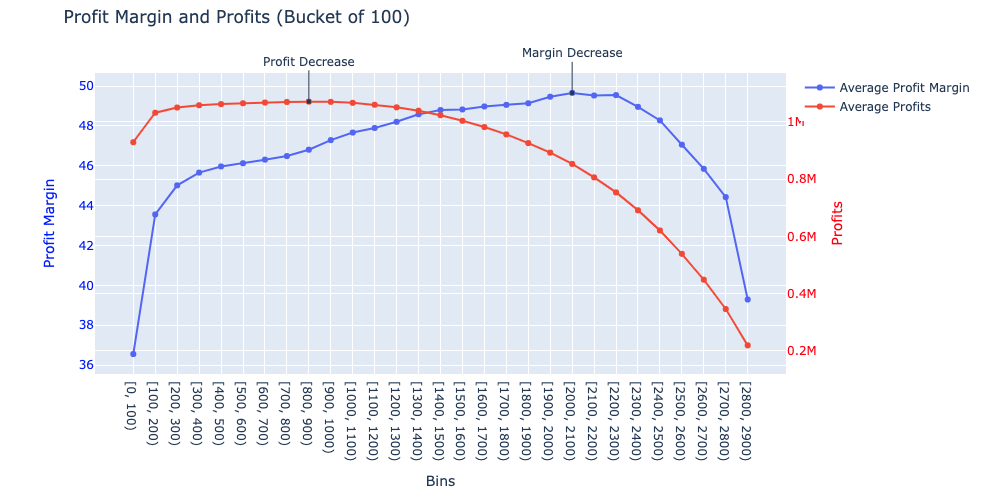

In [65]:
def updated(sellers_df, seller_id):
    # drop the seller
    sellers_df = sellers_df.iloc[seller_id:]

    # Calculate IT costs
    alpha = 3157.27
    beta = 978.23
    it_costs = alpha * np.sqrt(len(sellers_df)) + beta * np.sqrt(sellers_df['quantity'].sum())

    total_profits = sellers_df['profits'].sum() - it_costs
    total_revenues = sellers_df['revenues'].sum()
    profit_margin = (total_profits / total_revenues) * 100

    profits = sellers_df['profits'].sum() - it_costs

    return it_costs, profit_margin, profits

def optimal_n(sellers_df):
    # Initial profit margin and profits before removing any sellers
    total_profits = sellers_df['profits'].sum() - 500000
    total_revenues = sellers_df['revenues'].sum()
    initial_profit_margin = (total_profits / total_revenues) * 100

    initial_profits = sellers_df['profits'].sum() - 500000

    #profit_margin and profits after removing i sellers
    optimal_profit_margin = initial_profit_margin
    optimal_profits = initial_profits
    optimal_n_sellers = 0

    for i in range(len(sellers_df)):
        # Update IT costs, profit_margin, profits by removing i seller
        it_costs, profit_margin, profits = updated(sellers_df, i)

        # Check if current scenario improves profit margin and profits
        if profit_margin > optimal_profit_margin and profits > optimal_profits:
            optimal_profit_margin = profit_margin
            optimal_profits = profits
            optimal_n_sellers = i + 1  # Number of removed sellers


    return round(initial_profit_margin,2), round(initial_profits,2), round(optimal_n_sellers,2), round(optimal_profit_margin,2), round(optimal_profits,2)

# Execute the code
initial_profit_margin, initial_profits, optimal_n_sellers, profit_margin, profits = optimal_n(sellers_df)

# Print the results
print("Initial profit margin:", initial_profit_margin)
print("Initial profit:", initial_profits)
print("Optimal number of sellers to remove:", optimal_n_sellers)
print("Optimal profit margin:", profit_margin)
print("Optimal profits:", profits)

Initial profit margin: 23.96
Initial profit: 667608.44
Optimal number of sellers to remove: 856
Optimal profit margin: 46.91
Optimal profits: 1070976.12


## Profit Summary
- **Initial Profit Margin:** 23.96
- **Initial Profit:** 667,608.44

## Optimal Analysis
After further analysis, I found the best scenario to be:

- **Optimal Number of Sellers to Remove:** 856
- **Optimal Profit Margin:** 46.91
- **Optimal Profits:** 1,070,976.12



## Conclusion

Based on our "what-if" analysis, removing **856 sellers** could potentially optimize our profits by over **$400,000**. Please note that this is a hypothetical analysis and focuses on a specific segment of the company. Here are the recommendations:

1. **Improve Recruitment**: Implement a more effective recruitment strategy for new sellers. Attracting high-quality sellers will enhance service quality, reduce wait times, and boost both customer satisfaction and profits.

2. **Remove the Worst Performers**: Conduct an analysis to identify which sellers to remove and which could benefit from additional support. This will help in optimizing overall performance.

3. **Further Analysis on Location and Product**: Investigate further into the location and product aspects to gain deeper insights and refine strategies.

